## Subito
Alexis Garcia 

In [5]:
import requests
import bs4
from bs4 import BeautifulSoup
import xlsxwriter
import re
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import six

## Scraping subito

In [5]:


workbook = xlsxwriter.Workbook('dataset/collected.xlsx')
worksheet = workbook.add_worksheet('Used')
bold = workbook.add_format({'bold' : 1})

# cars, electronics, house, sports, sport-hobby, others
categories = ['motori', 'elettronica', 'casa-e-persona', 'sport-hobby', 'annunci-vari']

row = 1
col = 0

for category in categories:

    
    worksheet.set_column(0, 0, 50)
    worksheet.set_column(1, 1, 50)
    worksheet.set_column(2, 2, 50)
    worksheet.set_column(3, 3, 50)
    worksheet.write_string(0, 0, 'Item', bold)
    worksheet.write_string(0, 1, 'Price', bold)
    worksheet.write_string(0, 2, 'Category', bold)
    worksheet.write_string(0, 3, 'Region', bold)

    
    

    url = f'https://www.subito.it/annunci-italia/vendita/{category}'

    # current page number
    current = 1

    # subito only shows the first 300 
    while (current <= 300):
        response = requests.get(url)
        
        try:
            response.raise_for_status()
        except Exception as exc:
            print('There was a problem %s' % (exc))

        soup = BeautifulSoup(response.text, 'html.parser')
        
        results = soup.find_all('div', {'class': 'SmallCard-module_upper-data-group__aRFDu upper-data-group'})

        for i in results:
            title = i.find('h2', {'class': 'index-module_sbt-text-atom__ed5J9 index-module_token-h6__FGmXw size-normal index-module_weight-semibold__MWtJJ ItemTitle-module_item-title__VuKDo SmallCard-module_item-title__1y5U3'}).text

            price = i.find('p', {'class': 'index-module_price__N7M2x SmallCard-module_price__yERv7 price index-module_small__4SyUf'})
            
            if(price is None): # discarding results without price
                continue
            
            # html for pricing is inconsistent
            price = (price.text.replace('€', '').replace('\xa0Spedizione disponibile', '').replace('Spedizione disponibile', '').replace('.', '').strip())

            if(price == ''): # discarding results without price
                continue        
            
            price = float(price)

            location = i.find('span', {'class': 'index-module_sbt-text-atom__ed5J9 index-module_token-caption__TaQWv index-module_size-small__XFVFl index-module_weight-semibold__MWtJJ index-module_town__2H3jy'})
            if(location is None):
                location = 'Not provided'
            else: 
                location = location.text

            
            worksheet.write_string(row, col, title)
            worksheet.write_number(row, col + 1, price)
            worksheet.write_string(row, col + 2, category)
            worksheet.write_string(row, col + 3, location)

            row += 1

        # next page
        current += 1
        #nextLinkSuffix = '/?o=' + str(current)
        url = f'https://www.subito.it/annunci-italia/vendita/{category}//?o={current}'


workbook.close()

## price of equivalent new products from google shopping

In [18]:
def render_mpl_table(data, index_col_width=3.0, col_width=4.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w', 
                     bbox=[0, 0, 1, 1], header_columns=0, index='yes',
                     ax=None, **kwargs):
    if ax is None:       
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height]) + (index_col_width, 0)
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    
    if index=='no':
        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)        
    else:
        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, rowLabels=data.index, **kwargs)
    #mpl_table.auto_set_column_width(col=[0,1,2,3,4])
    mpl_table.auto_set_column_width(col=[0,1,2,3,4,5,6,7,8,9])

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)  

    for k, cell in six.iteritems(mpl_table._cells):        
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])        
        
    return ax


Selecting 10 representative products per category

In [6]:
excel_file = 'dataset/collected.xlsx'
df = pd.read_excel(excel_file)

df_selected_products = pd.DataFrame(columns=df.columns)

for category in df['Category'].unique().tolist():   
    
    df_category = df.loc[df['Category'] == category].copy() 
    mean_category = df_category['Price'].mean()
    df_selected_products = df_selected_products.append(df_category.iloc[(df_category['Price']-mean_category).abs().argsort()[:20]])
    
df_selected_products = df_selected_products.sort_values(by ='Category')

C:\Users\alexi\AppData\Local\Temp\ipykernel_65340\4005599174.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_selected_products = df_selected_products.append(df_category.iloc[(df_category['Price']-mean_category).abs().argsort()[:20]])
C:\Users\alexi\AppData\Local\Temp\ipykernel_65340\4005599174.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_selected_products = df_selected_products.append(df_category.iloc[(df_category['Price']-mean_category).abs().argsort()[:20]])
C:\Users\alexi\AppData\Local\Temp\ipykernel_65340\4005599174.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

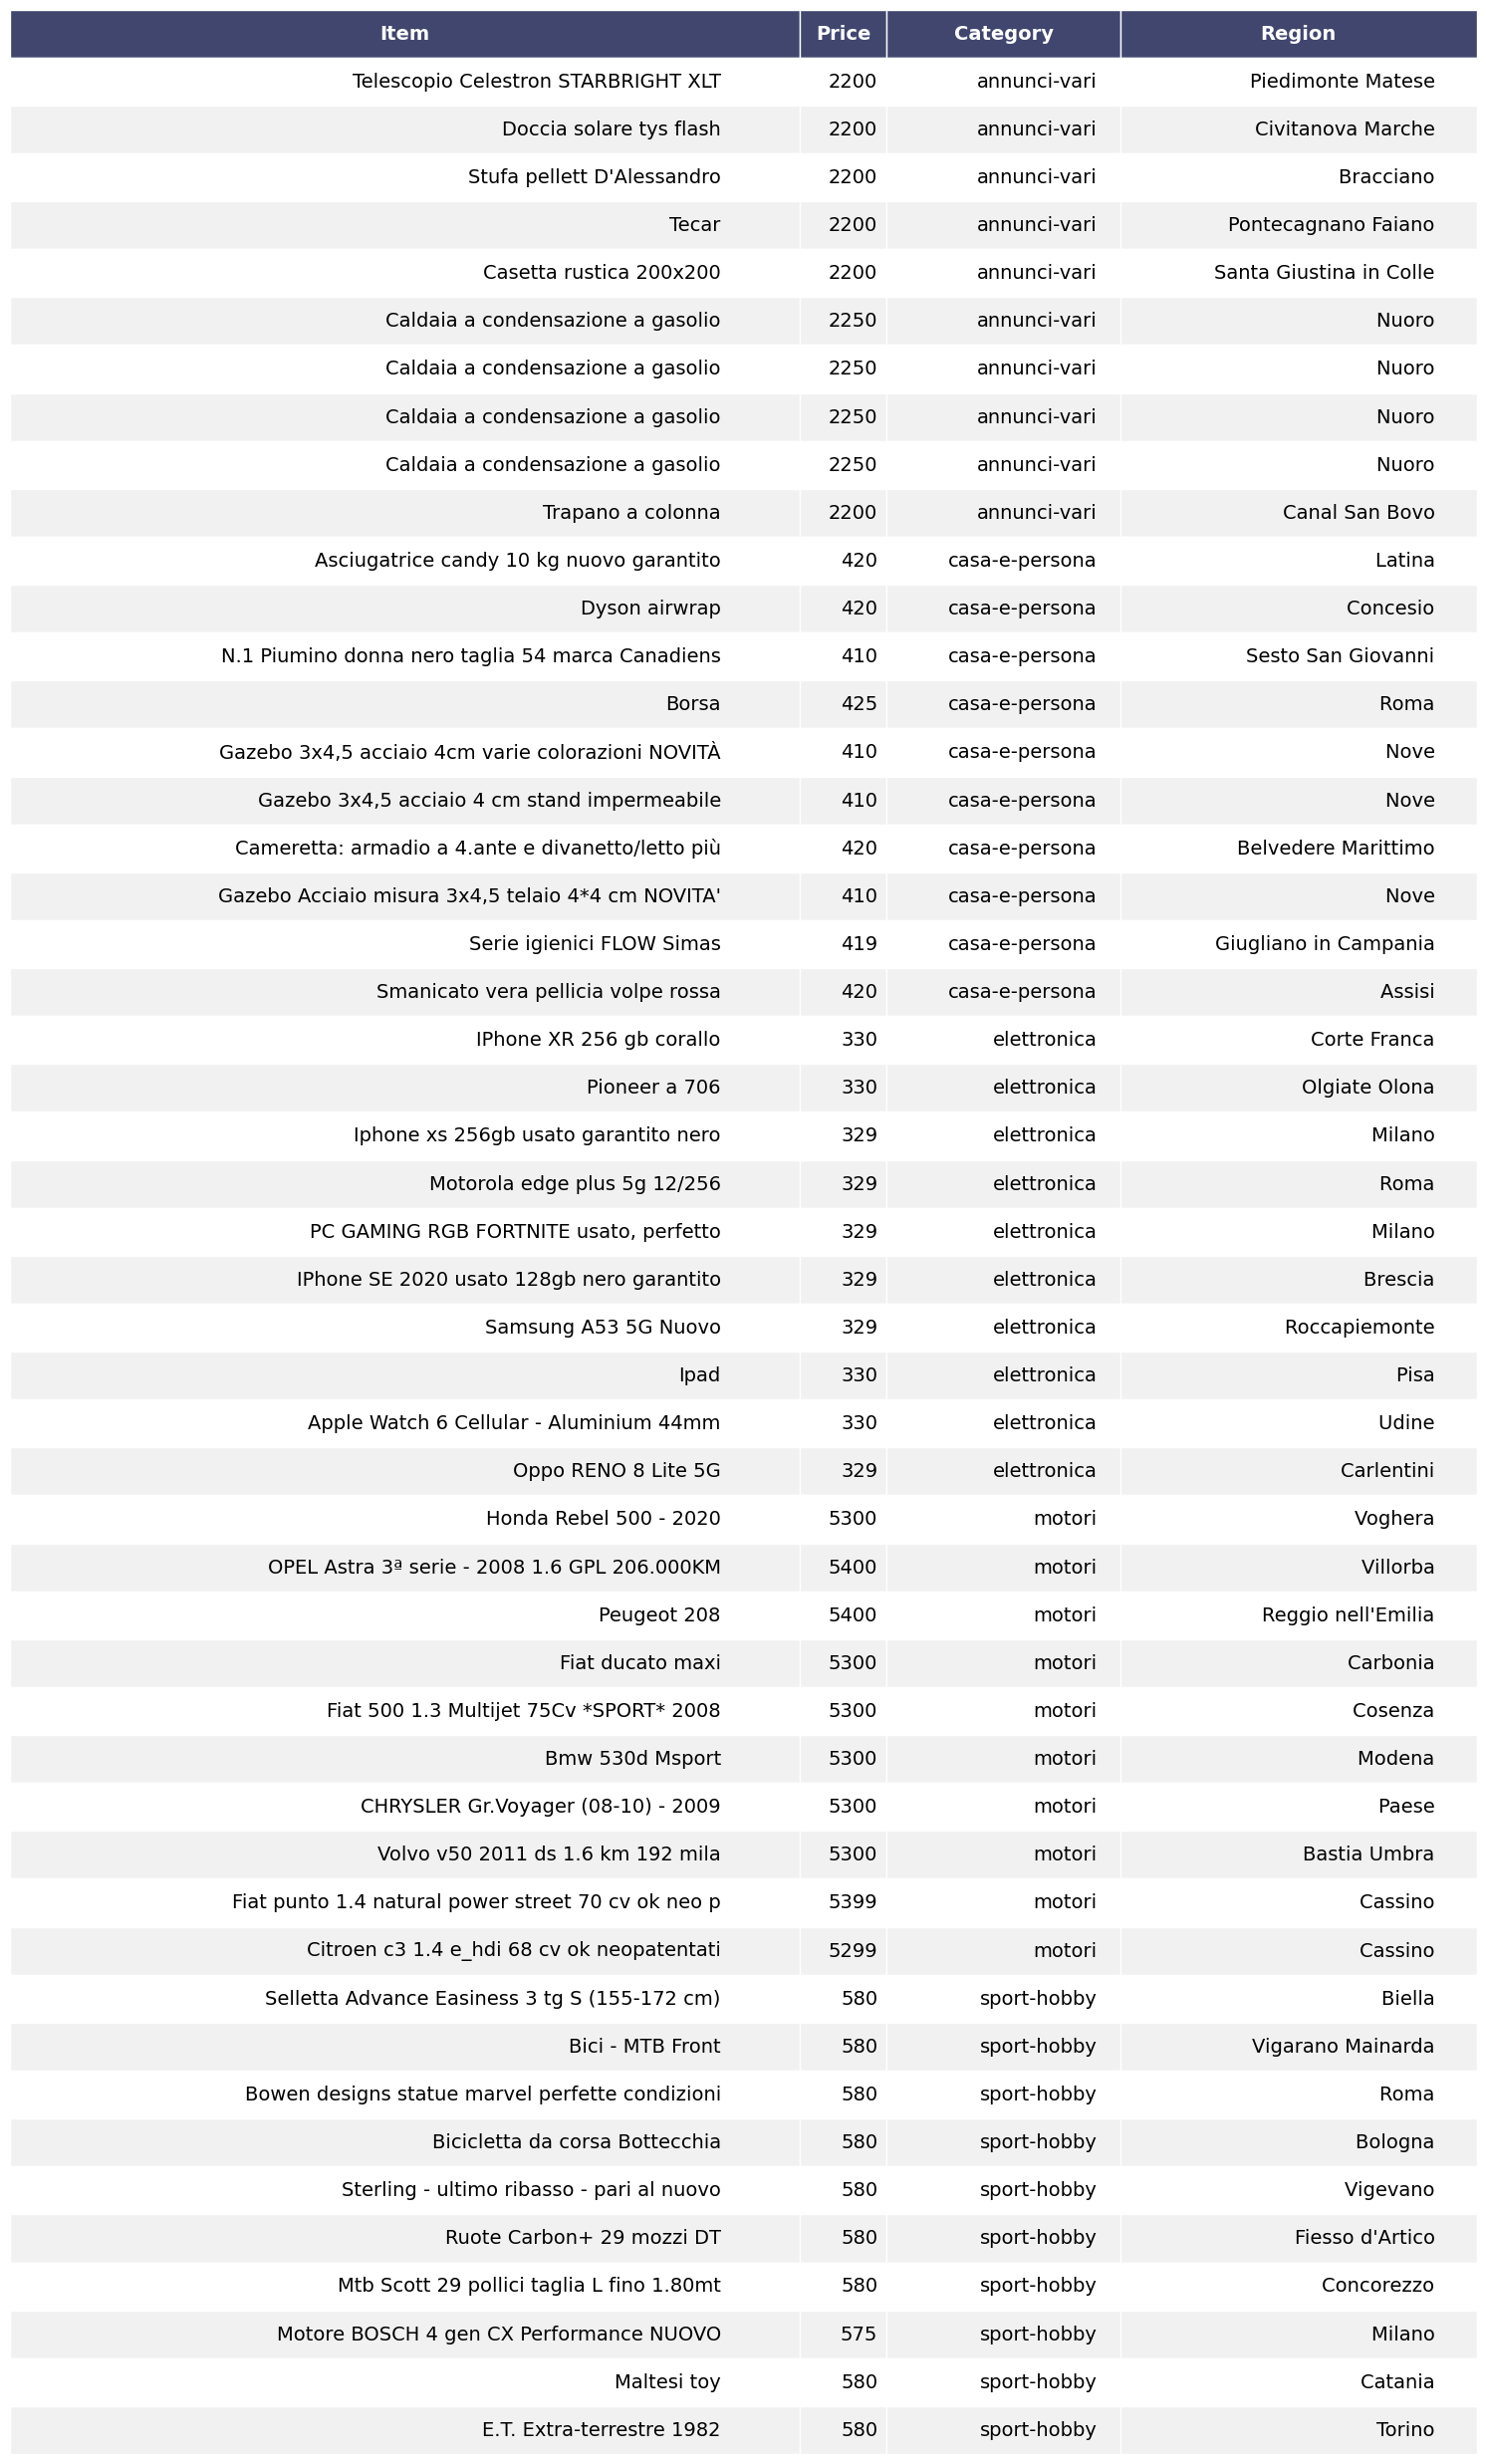

In [19]:
fig = render_mpl_table(df_selected_products, header_columns=0, col_width=4.0, index='no').get_figure()

In [8]:
average_prices_of_new_items = []
sources = []

url = 'https://www.google.com/search?tbm=shop&hl=it-IT&q='
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.70 Safari/13.0.3 '}

for item, priceUsed in zip(df_selected_products['Item'].tolist(), df_selected_products['Price'].tolist()):
    
    item_url = item.replace('usato', '').replace('  ', '').replace(" ", "%20")
    search_url = url + item_url
    
    print(search_url)

    response = requests.get(search_url, headers=headers)
    # response = requests.get(url)

    try:    
        response.raise_for_status() 
    except Exception as exc:    
         print('There was a problem: %s' % (exc))


    soup = BeautifulSoup(response.text, "html.parser")

    # all_prices = soup.find_all("div", ['sh-dlr__content','sh-dgr__offer-content'])   
    all_prices = soup.find_all("div", {'class': 'sh-dgr__gr-auto sh-dgr__grid-result'})    
    
    sum = 0.0       
    number_of_new_products = 0

    for one_price in all_prices:    
        
        price_span = one_price.find('span', attrs={'class': 'hahPbb'})      

        if price_span is None:
                continue

        is_used = one_price.find('span', attrs={'class': 'tD1ls'})        
        if is_used is None:

            if '€' not in price_span.text: # discarding values that are not in euros
                continue

            price_new_item = float(price_span.text.replace("€", "").replace(".", "").replace('(', '').replace(')', '').replace(u'\xa0', ' ').replace(",", ".").replace(" ", "").strip())   
            print(f'price: {price_new_item}')
            
            
            if (price_new_item > priceUsed):            
                sum = sum + price_new_item
                number_of_new_products = number_of_new_products + 1            
    
    if number_of_new_products != 0:
        average_price_of_new_item = sum/number_of_new_products
        # source = "(Google Shopping, 2022)"
    else:
        average_price_of_new_item = 0 
        source = ""
    
    average_prices_of_new_items.append(average_price_of_new_item)
    sources.append(source)

https://www.google.com/search?tbm=shop&hl=it-IT&q=Transpallet%20uomo%20a%20bordo
https://www.google.com/search?tbm=shop&hl=it-IT&q=Caldaia%20a%20condensazione%20a%20gasolio
price: 891.0
price: 1729.0
price: 839.0
price: 899.0
price: 1257.0
price: 824.0
price: 1540.0
price: 960.0
price: 2169.0
price: 1270.0
price: 2121.0
price: 1629.0
price: 1199.0
price: 75.0
price: 125.0
price: 55.0
https://www.google.com/search?tbm=shop&hl=it-IT&q=Caldaia%20a%20condensazione%20a%20gasolio
price: 891.0
price: 1729.0
price: 839.0
price: 899.0
price: 1257.0
price: 824.0
price: 1540.0
price: 960.0
price: 2169.0
price: 1270.0
price: 2121.0
price: 1629.0
price: 1199.0
price: 75.0
price: 125.0
price: 55.0
https://www.google.com/search?tbm=shop&hl=it-IT&q=Caldaia%20a%20condensazione%20a%20gasolio
price: 891.0
price: 1729.0
price: 839.0
price: 899.0
price: 1355.0
price: 1270.0
price: 2699.0
price: 824.0
price: 1540.0
price: 960.0
price: 1629.0
price: 1999.0
price: 1099.0
price: 75.0
price: 55.0
price: 125.0
h

In [17]:
idx=2
df_price_comparison = df_selected_products.copy()
df_price_comparison.insert(loc=idx, column='Value retained [EU]', value = (average_prices_of_new_items - df_selected_products['Price']))
df_price_comparison.insert(loc=idx, column='Price new product [EU]', value = average_prices_of_new_items)
df_price_comparison = df_price_comparison.drop(['Region'], axis=1)
df_price_comparison = df_price_comparison.rename(columns={'Price': 'Price used product [EU]'}) 

In [18]:
df_price_comparison.to_csv('dataset/df_price_comparison_scraped_data.csv', index=False)
df_price_comparison = df_price_comparison[df_price_comparison['Price new product [EU]'] != 0] # discarding incomplete items
df_price_comparison.style.hide_index()

C:\Users\alexi\AppData\Local\Temp\ipykernel_65340\3282261528.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df_price_comparison.style.hide_index()


Item,Price used product [EU],Price new product [EU],Value retained [EU],Category
Caldaia a condensazione a gasolio,2250,2699.000000,449.000000,annunci-vari
Caldaia a condensazione a gasolio,2250,2699.000000,449.000000,annunci-vari
Casetta rustica 200x200,2200,3140.333333,940.333333,annunci-vari
Scooter elettrico per disabili,2200,4580.330000,2380.330000,annunci-vari
Girarrosto universo 14 stecche,2200,5467.226667,3267.226667,annunci-vari
Scooter elettrico per disabili,2200,4580.330000,2380.330000,annunci-vari
"Gazebo 3x4,5 acciaio 4 cm stand impermeabile",410,2866.310000,2456.310000,casa-e-persona
"Gazebo 3x4,5 acciaio 4cm varie colorazioni NOVITÀ",410,2866.310000,2456.310000,casa-e-persona
"Gazebo Acciaio misura 3x4,5 telaio 4*4 cm NOVITA'",410,2866.310000,2456.310000,casa-e-persona
N.1 Piumino donna nero taglia 54 marca Canadiens,410,803.291667,393.291667,casa-e-persona
